# **Develop a machine learning model to predict tool wear failures in a milling machine based on sensor data.**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc


Penjelasan:

1. `import pandas as pd`: Mengimpor library Pandas untuk manipulasi dan analisis data. Pandas menyediakan struktur data yang efisien seperti DataFrame.

2. `import numpy as np`: Mengimpor library NumPy untuk komputasi numerik. NumPy digunakan untuk operasi array dan matriks.

3. `import seaborn as sns`: Mengimpor Seaborn, library visualisasi data berbasis Matplotlib. Seaborn menyediakan antarmuka tingkat tinggi untuk membuat grafik statistik yang menarik.

4. `import matplotlib.pyplot as plt`: Mengimpor modul pyplot dari Matplotlib untuk membuat visualisasi data. Matplotlib adalah library plotting dasar di Python.

5. `from sklearn.model_selection import train_test_split`: Mengimpor fungsi train_test_split dari scikit-learn untuk membagi dataset menjadi set pelatihan dan pengujian.

6. `from sklearn.preprocessing import StandardScaler`: Mengimpor StandardScaler dari scikit-learn untuk menstandarisasi fitur-fitur dataset.

7. `from sklearn.linear_model import LogisticRegression`: Mengimpor kelas LogisticRegression dari scikit-learn untuk implementasi model regresi logistik.

8. `from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc`: Mengimpor berbagai metrik evaluasi model dari scikit-learn, termasuk laporan klasifikasi, matriks konfusi, skor akurasi, kurva ROC, dan AUC.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

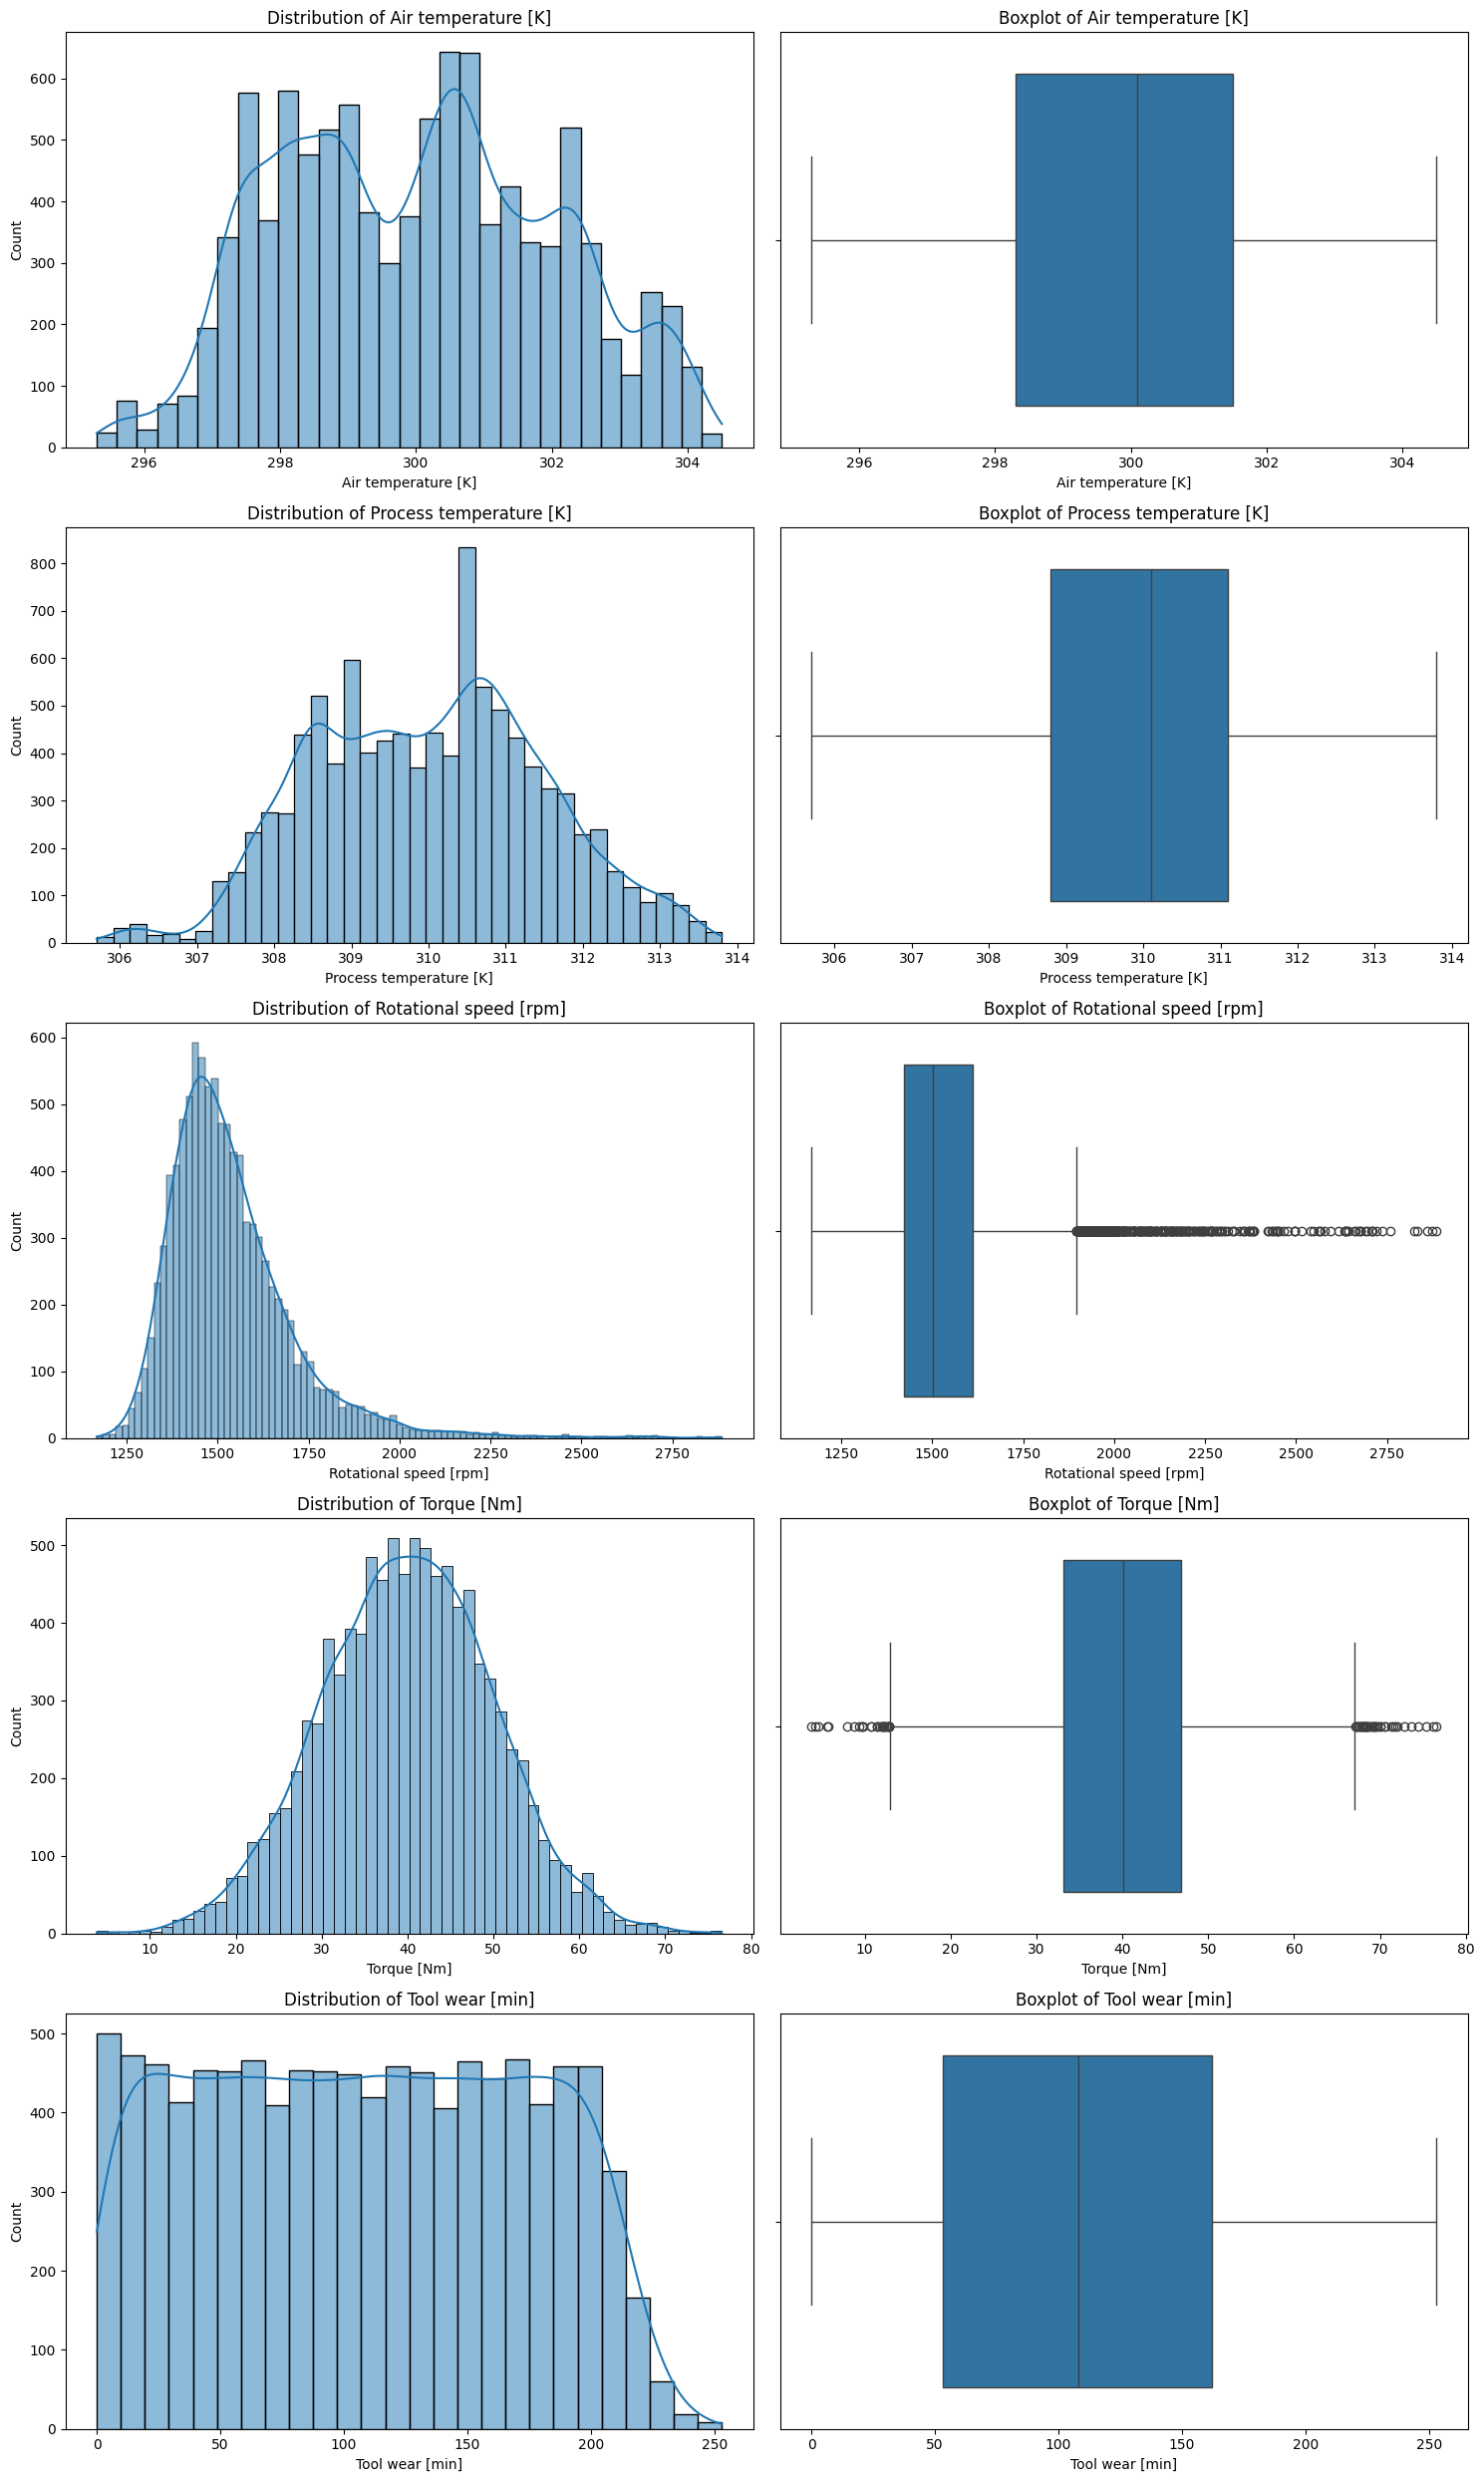

In [ ]:
data = pd.read_csv('ai4i2020.csv')

# Display basic information
print(data.info())
print(data.describe())

# Visualize data distribution and outliers
numerical_columns = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(15, 25))
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {col}')
    sns.boxplot(x=data[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


1. Air temperature [K]:
   - Distribusi: Terlihat multimodal (beberapa puncak), dengan rentang sekitar 295-305 K.
   - Boxplot: Menunjukkan distribusi yang cukup simetris, dengan beberapa outlier di kedua ujungnya.

2. Process temperature [K]:
   - Distribusi: Cenderung normal dengan sedikit kemiringan positif, rentang sekitar 305-314 K.
   - Boxplot: Relatif simetris dengan beberapa outlier di bagian atas.

3. Rotational speed [rpm]:
   - Distribusi: Sangat miring ke kanan (right-skewed), dengan mayoritas data terkonsentrasi di sekitar 1400-1500 rpm.
   - Boxplot: Menunjukkan banyak outlier di sisi kanan, yang mengindikasikan beberapa kejadian dengan kecepatan rotasi yang sangat tinggi.

4. Torque [Nm]:
   - Distribusi: Mendekati normal, sedikit miring ke kanan, dengan rentang utama sekitar 20-70 Nm.
   - Boxplot: Cukup simetris dengan beberapa outlier di kedua sisi, terutama di sisi atas.

5. Tool wear [min]:
   - Distribusi: Cenderung seragam (uniform) dari 0 hingga sekitar 200 menit, dengan penurunan tajam setelahnya.
   - Boxplot: Menunjukkan distribusi yang luas dan relatif merata, dengan beberapa outlier di bagian atas.

In [ ]:
# Remove outliers
for col in numerical_columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]



1. Kode ini melakukan proses penghapusan outlier menggunakan metode IQR (Interquartile Range) untuk setiap kolom numerik yang telah didefinisikan sebelumnya.

2. Loop `for` digunakan untuk mengiterasi setiap kolom dalam `numerical_columns`.

3. Untuk setiap kolom:
   - `q1 = data[col].quantile(0.25)`: Menghitung kuartil pertama (25th percentile).
   - `q3 = data[col].quantile(0.75)`: Menghitung kuartil ketiga (75th percentile).
   - `iqr = q3 - q1`: Menghitung IQR (selisih antara kuartil ketiga dan pertama).

4. Menentukan batas atas dan bawah untuk outlier:
   - `lower_bound = q1 - 1.5 * iqr`: Batas bawah dihitung sebagai Q1 - 1.5 * IQR.
   - `upper_bound = q3 + 1.5 * iqr`: Batas atas dihitung sebagai Q3 + 1.5 * IQR.

5. `data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]`:
   Memfilter DataFrame untuk hanya menyimpan baris di mana nilai kolom berada di antara batas bawah dan batas atas. Ini efektif menghapus outlier.

In [ ]:
# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Type'])

# Prepare features and target
X = data.drop(['UDI', 'Product ID', 'Machine failure'], axis=1)
y = data['Machine failure']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Pada bagian ini akan melakukan persiapan data untuk pemodelan. Pertama, variabel kategorikal 'Type' diubah menjadi representasi one-hot encoding menggunakan `pd.get_dummies()`. Kemudian, fitur-fitur (X) dipisahkan dari variabel target (y), dengan menghapus kolom yang tidak relevan. Terakhir, data dibagi menjadi set pelatihan dan pengujian menggunakan `train_test_split()` dengan 80% data untuk pelatihan dan 20% untuk pengujian. Langkah-langkah ini penting untuk mempersiapkan data agar bisa digunakan dalam model pembelajaran mesin, memastikan bahwa semua variabel dalam format numerik yang sesuai, dan menyediakan cara untuk mengevaluasi performa model pada data yang belum pernah dilihat sebelumnya.

In [ ]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


StandardScaler menormalisasi fitur dengan mengurangkan mean dan membagi dengan standar deviasi, sehingga setiap fitur memiliki mean 0 dan varians 1.

In [ ]:
# Train logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Make predictions
y_pred_log = log_model.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))


Accuracy: 0.9984268484530676
Confusion Matrix:
 [[1848    0]
 [   3   56]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      0.95      0.97        59

    accuracy                           1.00      1907
   macro avg       1.00      0.97      0.99      1907
weighted avg       1.00      1.00      1.00      1907



Proses latih model regresi logistik, melakukan prediksi, dan mengevaluasi performa model.

1. Model regresi logistik dilatih menggunakan data latih.
2. Prediksi dilakukan pada data uji.
3. Performa model dievaluasi menggunakan beberapa metrik:

Interpretasi output:
- Akurasi: 0.9984 (99.84%), menunjukkan performa yang sangat baik.
- Matriks Konfusi:
  [[1848    0]
  [   3   56]]
  - 1848 True Negatives (prediksi benar untuk non-kegagalan)
  - 56 True Positives (prediksi benar untuk kegagalan)
  - 3 False Negatives (kegagalan yang tidak terdeteksi)
  - 0 False Positives (tidak ada prediksi kegagalan yang salah)

- Laporan Klasifikasi:
  - Presisi, recall, dan F1-score sangat tinggi untuk kedua kelas.
  - Kelas 0 (non-kegagalan): Sempurna dalam semua metrik.
  - Kelas 1 (kegagalan): Presisi 1.00, recall 0.95, F1-score 0.97.

Kesimpulan: Model menunjukkan performa yang luar biasa, dengan akurasi hampir sempurna dan kemampuan yang sangat baik dalam mendeteksi *Machine Failure*

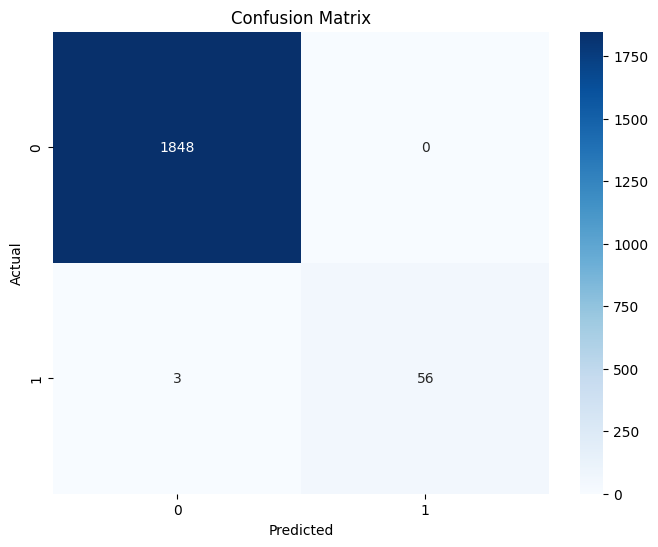

In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


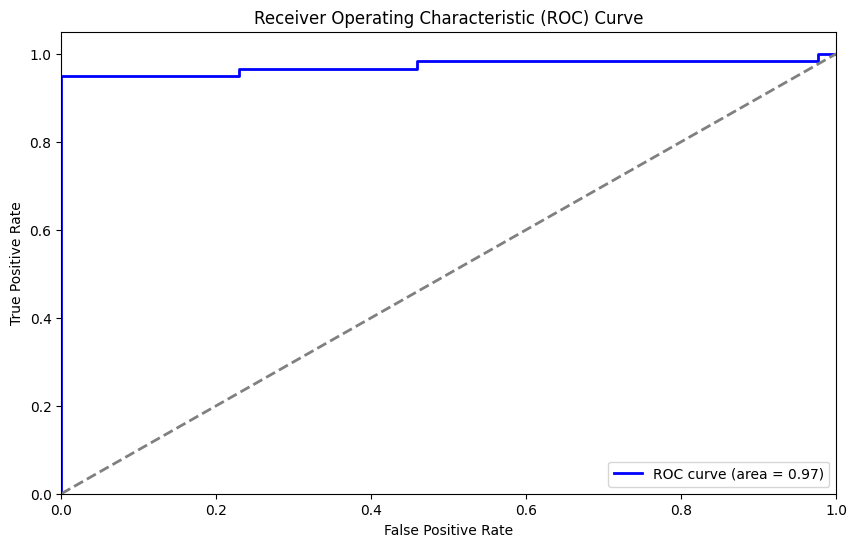

In [ ]:
# ROC Curve
y_pred_prob = log_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


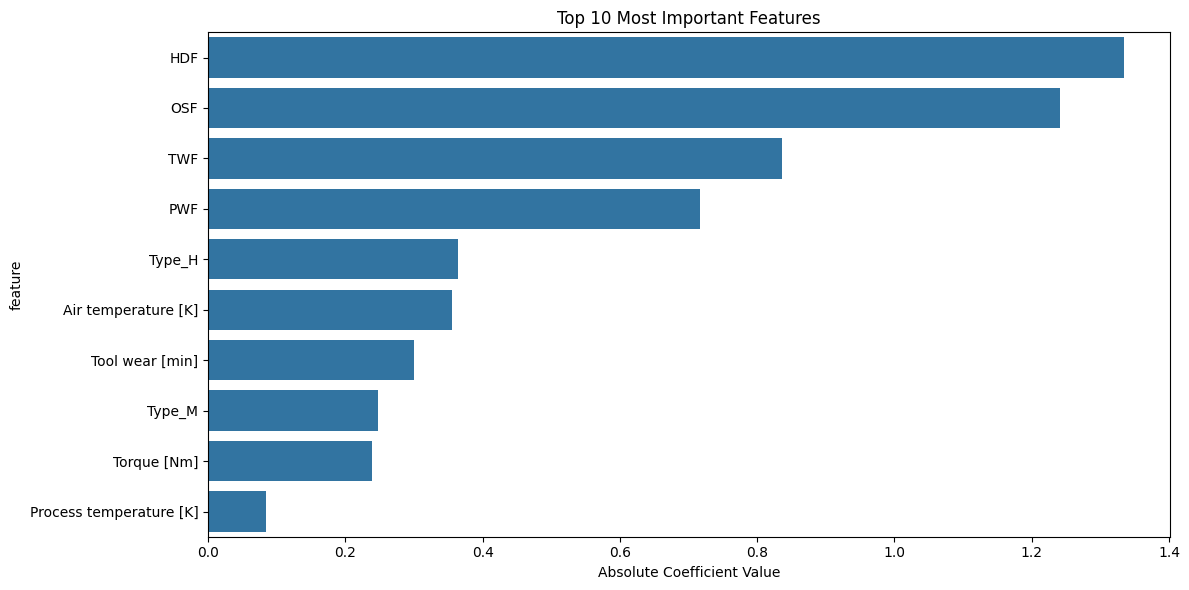

In [ ]:
# Additional visualization: Feature Importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': abs(log_model.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()


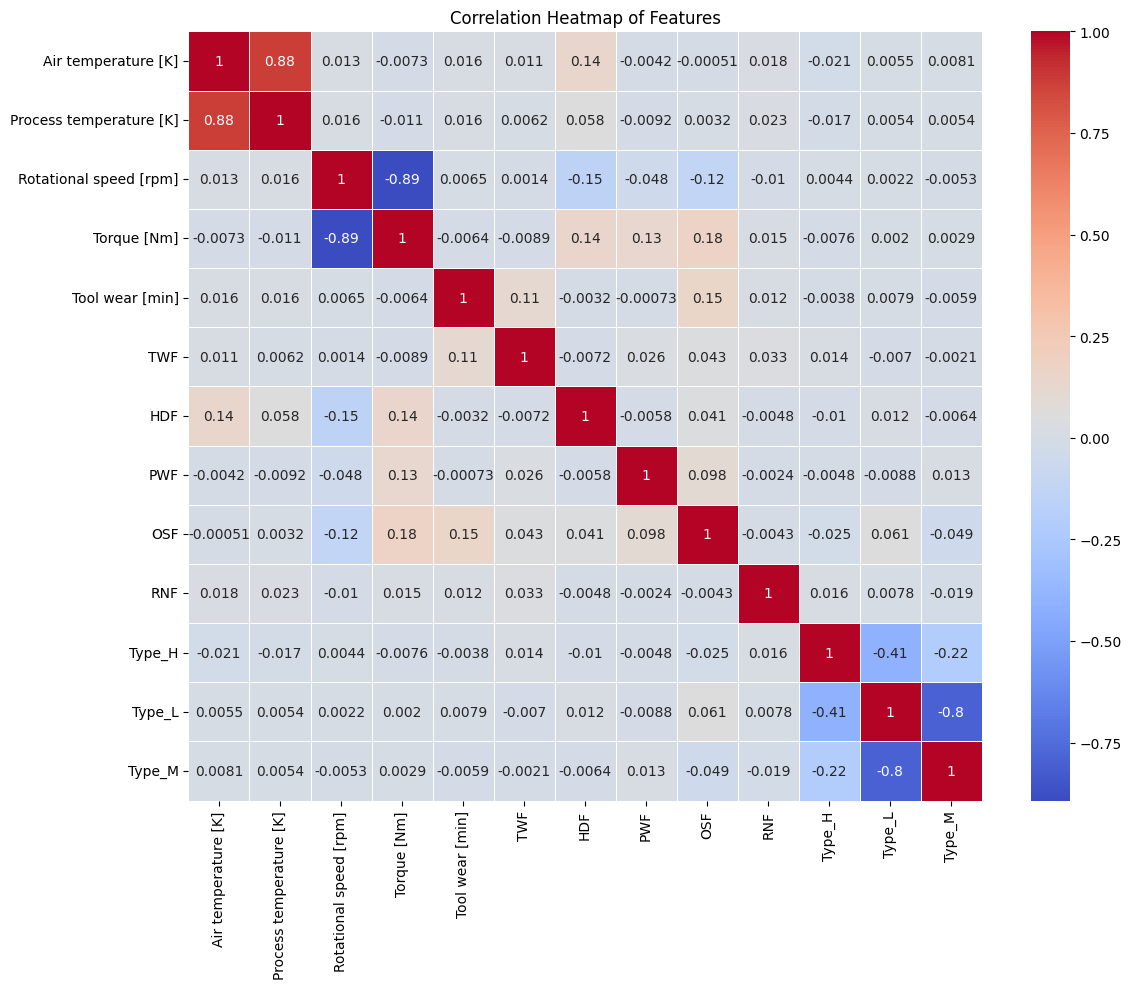

In [ ]:
# Additional visualization: Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()